# Machine Learning Homework #4

Michael Li

Nov 27, 2017

## Environment Setup 

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data 
import sklearn
import timeit
import datetime
# Suppress warnings
import warnings
warnings.simplefilter('ignore')

## Load dataset

In [2]:
# load dataset
mnisttt = input_data.read_data_sets(".", one_hot=True, validation_size = 0)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
# define function to plot images
def image_plot(image, size):
    idxs = np.random.randint(len(image), size=size)
    plt.clf()
    f, axarr = plt.subplots(1, size, figsize = (20,20))
    for i in range(0,len(idxs)):
        X = mnisttt.train.images[idxs[i]]
        X = X.reshape([28, 28])
        axarr[i].imshow(X)
        axarr[i].set_axis_off()
    plt.show()

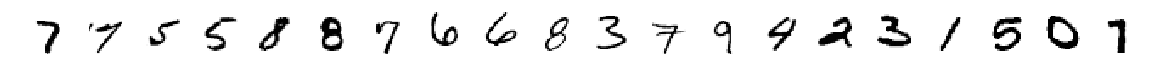

In [4]:
# plot 20 random images
image_plot(mnisttt.train.images, 20)

In [5]:
# print dataset size
print('The size of training image dataset is: ', mnisttt.train.images.shape)
print('The size of training label dataset is: ', mnisttt.train.labels.shape)
print('The size of validation image dataset is: ', mnisttt.validation.images.shape)
print('The size of validation label dataset is: ', mnisttt.validation.labels.shape)
print('The size of testing image dataset is: ', mnisttt.test.images.shape)
print('The size of testing label dataset is: ', mnisttt.test.labels.shape)

The size of training image dataset is:  (60000, 784)
The size of training label dataset is:  (60000, 10)
The size of validation image dataset is:  (0, 784)
The size of validation label dataset is:  (0, 10)
The size of testing image dataset is:  (10000, 784)
The size of testing label dataset is:  (10000, 10)


## MLP Classifier

In [6]:
# use tensorflow to construct MLP Classifier
# set parameters
n_iter = [100, 200, 250]
learning_rate = [0.0001, 0.001, 0.01]
training_epochs = 30
# since the training epochs = 30, the batch size = (60000 / 30) / n_iter
batch_size = [int(mnisttt.train.num_examples/training_epochs/i) for i in n_iter]
l2_beta = [0.01,0.1,1,10]
display_step = 1
n_hidden = [32, 64, 128]
n_input = 784
n_classes = 10

In [22]:
batch_size

[20, 10, 8]

In [7]:
# tf graph input
X = tf.placeholder('float', [None, n_input])
Y = tf.placeholder('float',[None, n_classes])

In [8]:
# create model
def mlp(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

In [9]:
# construct and test MLP classifier with different hidden layer units 
n_hidden_list = []
epoch_list = []
cost_list = []
train_accuracy_list = []
test_accuracy_list = []
for n in n_hidden:
    start = timeit.default_timer()
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n])),
        'h2': tf.Variable(tf.random_normal([n, n])),
        'out': tf.Variable(tf.random_normal([n, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n])),
        'b2': tf.Variable(tf.random_normal([n])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    # construct model
    mlp_clf = mlp(X)
    # define loss function using L2 regularization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = mlp_clf, 
                                                                  labels= Y))
    regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out'])
    loss_op = tf.reduce_mean(loss + l2_beta[0] * regularizer)
    # define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate[0])
    train_op = optimizer.minimize(loss_op)
    # initialize variables
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        # training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(mnisttt.train.num_examples/batch_size[0])
            # loop over all batches
            for k in range(total_batch):
                batch_x, batch_y = mnisttt.train.next_batch(batch_size[0])
                # run optimization op and cost op
                _, c = sess.run([train_op, loss_op], feed_dict = {X: batch_x, Y: batch_y})
                # compute average loss
                avg_cost += c/ total_batch
            # test model
            pred = tf.nn.softmax(mlp_clf)
            correction_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
            # calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correction_prediction, 'float'))
            # display logs per epoch step
            if epoch % display_step == 0:
                n_hidden_list.append(n)
                epoch_list.append(epoch + 1)
                cost_list.append(avg_cost)
                train_accuracy_list.append(accuracy.eval({X: mnisttt.train.images, 
                                                          Y: mnisttt.train.labels}))
                test_accuracy_list.append(accuracy.eval({X: mnisttt.test.images, 
                                                         Y: mnisttt.test.labels}))
    print(n_iter[0], learning_rate[0], l2_beta[0], n)
    stop = timeit.default_timer()
    clf_lsvm_time = stop - start
    print('Running time: %.3f' % (stop - start))


100 0.0001 0.01 32
Running time: 156.950
100 0.0001 0.01 64
Running time: 179.506
100 0.0001 0.01 128
Running time: 243.654


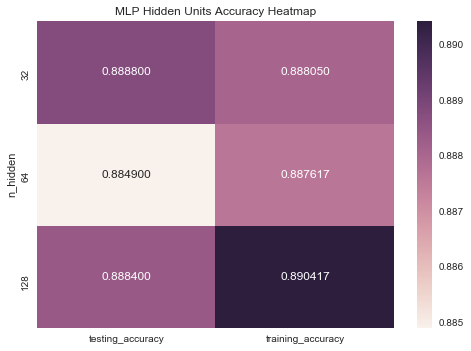

In [10]:
df_mlp_hidden = pd.DataFrame({ 'n_hidden': n_hidden_list, 'epoch': epoch_list, 
                              'training_accuracy': train_accuracy_list, 'testing_accuracy': test_accuracy_list})
df_mlp_hidden_best = df_mlp_hidden[df_mlp_hidden['epoch'] == 30]
df_mlp_hidden_best.set_index('n_hidden', inplace = True)
# display the result
plt.clf()

fig_mlp_hidden = sns.heatmap(df_mlp_hidden_best[['testing_accuracy', 'training_accuracy']], annot=True, fmt='f')
plt.subplots_adjust(top=0.9)
fig_mlp_hidden.set_title('MLP Hidden Units Accuracy Heatmap')

plt.show()

The best parameter for units in hidden layers is 128.

Different hidden layer units have small effects on accuracy.

In [11]:
# construct and test MLP classifier with different L2 regularization beta
l2_beta_list = []
epoch_list = []
cost_list = []
train_accuracy_list = []
test_accuracy_list = []
for m in l2_beta:
    start = timeit.default_timer()
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden[2]])),
        'h2': tf.Variable(tf.random_normal([n_hidden[2], n_hidden[2]])),
        'out': tf.Variable(tf.random_normal([n_hidden[2], n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden[2]])),
        'b2': tf.Variable(tf.random_normal([n_hidden[2]])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    # construct model
    mlp_clf = mlp(X)
    # define loss function using L2 regularization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = mlp_clf, 
                                                                  labels= Y))
    regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out'])
    loss_op = tf.reduce_mean(loss + m * regularizer)
    # define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate[0])
    train_op = optimizer.minimize(loss_op)
    # initialize variables
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        # training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(mnisttt.train.num_examples/batch_size[0])
            # loop over all batches
            for k in range(total_batch):
                batch_x, batch_y = mnisttt.train.next_batch(batch_size[0])
                # run optimization op and cost op
                _, c = sess.run([train_op, loss_op], feed_dict = {X: batch_x, Y: batch_y})
                # compute average loss
                avg_cost += c/ total_batch
            # test model
            pred = tf.nn.softmax(mlp_clf)
            correction_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
            # calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correction_prediction, 'float'))
            # display logs per epoch step
            if epoch % display_step == 0:
                l2_beta_list.append(m)
                epoch_list.append(epoch + 1)
                cost_list.append(avg_cost)
                train_accuracy_list.append(accuracy.eval({X: mnisttt.train.images, 
                                                          Y: mnisttt.train.labels}))
                test_accuracy_list.append(accuracy.eval({X: mnisttt.test.images, 
                                                         Y: mnisttt.test.labels}))
    print(n_iter[0], learning_rate[0], m, n_hidden[2])
    stop = timeit.default_timer()
    print('Running time: %.3f' % (stop - start))

100 0.0001 0.01 128
Running time: 204.370
100 0.0001 0.1 128
Running time: 200.266
100 0.0001 1 128
Running time: 199.406
100 0.0001 10 128
Running time: 240.699


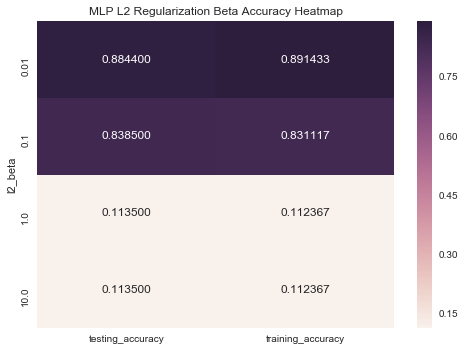

In [13]:
df_mlp_l2 = pd.DataFrame({ 'l2_beta': l2_beta_list, 'epoch': epoch_list, 
                              'training_accuracy': train_accuracy_list, 'testing_accuracy': test_accuracy_list})
df_mlp_l2_best = df_mlp_l2[df_mlp_l2['epoch'] == 30]
df_mlp_l2_best.set_index('l2_beta', inplace = True)
# display the result
plt.clf()

fig_mlp_l2 = sns.heatmap(df_mlp_l2_best[['testing_accuracy', 'training_accuracy']], annot=True, fmt='f')
plt.subplots_adjust(top=0.9)
fig_mlp_l2.set_title('MLP L2 Regularization Beta Accuracy Heatmap')

plt.show()

The best parameter for L2 regularization beta is 0.01.

Different L2 regularization parameter have huge impact on accuracy.

In [9]:
# construct and test MLP classifier with different Learning rate
learning_rate_list = []
epoch_list = []
cost_list = []
train_accuracy_list = []
test_accuracy_list = []
for j in learning_rate:
    start = timeit.default_timer()
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden[2]])),
        'h2': tf.Variable(tf.random_normal([n_hidden[2], n_hidden[2]])),
        'out': tf.Variable(tf.random_normal([n_hidden[2], n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden[2]])),
        'b2': tf.Variable(tf.random_normal([n_hidden[2]])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    # construct model
    mlp_clf = mlp(X)
    # define loss function using L2 regularization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = mlp_clf, 
                                                                  labels= Y))
    regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out'])
    loss_op = tf.reduce_mean(loss + l2_beta[0] * regularizer)
    # define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate= j)
    train_op = optimizer.minimize(loss_op)
    # initialize variables
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        # training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(mnisttt.train.num_examples/batch_size[0])
            # loop over all batches
            for k in range(total_batch):
                batch_x, batch_y = mnisttt.train.next_batch(batch_size[0])
                # run optimization op and cost op
                _, c = sess.run([train_op, loss_op], feed_dict = {X: batch_x, Y: batch_y})
                # compute average loss
                avg_cost += c/ total_batch
            # test model
            pred = tf.nn.softmax(mlp_clf)
            correction_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
            # calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correction_prediction, 'float'))
            # display logs per epoch step
            if epoch % display_step == 0:
                learning_rate_list.append(j)
                epoch_list.append(epoch + 1)
                cost_list.append(avg_cost)
                train_accuracy_list.append(accuracy.eval({X: mnisttt.train.images, 
                                                          Y: mnisttt.train.labels}))
                test_accuracy_list.append(accuracy.eval({X: mnisttt.test.images, 
                                                         Y: mnisttt.test.labels}))
    print(n_iter[0], j, l2_beta[0], n_hidden[2])
    stop = timeit.default_timer()
    print('Running time: %.3f' % (stop - start))

100 0.0001 0.01 128
Running time: 227.128
100 0.001 0.01 128
Running time: 232.197
100 0.01 0.01 128
Running time: 236.814


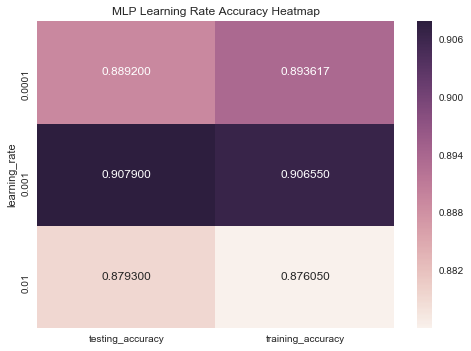

In [10]:
df_mlp_learning = pd.DataFrame({ 'learning_rate': learning_rate_list, 'epoch': epoch_list, 
                              'training_accuracy': train_accuracy_list, 'testing_accuracy': test_accuracy_list})
df_mlp_learning_best = df_mlp_learning[df_mlp_learning['epoch'] == 30]
df_mlp_learning_best.set_index('learning_rate', inplace = True)
# display the result
plt.clf()

fig_mlp_learning = sns.heatmap(df_mlp_learning_best[['testing_accuracy', 'training_accuracy']], annot=True, fmt='f')
plt.subplots_adjust(top=0.9)
fig_mlp_learning.set_title('MLP Learning Rate Accuracy Heatmap')

plt.show()

The best learning rate is 0.001.

Different learning rates have small effect on the accuracy.

In [15]:
# construct and test MLP classifier with different number of iterations
n_iter_list = []
epoch_list = []
cost_list = []
train_accuracy_list = []
test_accuracy_list = []
for i in range(len(n_iter)):
    start = timeit.default_timer()
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden[2]])),
        'h2': tf.Variable(tf.random_normal([n_hidden[2], n_hidden[2]])),
        'out': tf.Variable(tf.random_normal([n_hidden[2], n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden[2]])),
        'b2': tf.Variable(tf.random_normal([n_hidden[2]])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    # construct model
    mlp_clf = mlp(X)
    # define loss function using L2 regularization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = mlp_clf, 
                                                                  labels= Y))
    regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out'])
    loss_op = tf.reduce_mean(loss + l2_beta[0] * regularizer)
    # define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate[1])
    train_op = optimizer.minimize(loss_op)
    # initialize variables
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        # training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(mnisttt.train.num_examples/batch_size[i])
            # loop over all batches
            for k in range(total_batch):
                batch_x, batch_y = mnisttt.train.next_batch(batch_size[i])
                # run optimization op and cost op
                _, c = sess.run([train_op, loss_op], feed_dict = {X: batch_x, Y: batch_y})
                # compute average loss
                avg_cost += c/ total_batch
            # test model
            pred = tf.nn.softmax(mlp_clf)
            correction_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
            # calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correction_prediction, 'float'))
            # display logs per epoch step
            if epoch % display_step == 0:
                n_iter_list.append(n_iter[i])
                epoch_list.append(epoch + 1)
                cost_list.append(avg_cost)
                train_accuracy_list.append(accuracy.eval({X: mnisttt.train.images, 
                                                          Y: mnisttt.train.labels}))
                test_accuracy_list.append(accuracy.eval({X: mnisttt.test.images, 
                                                         Y: mnisttt.test.labels}))
    print(n_iter[i], learning_rate[1], l2_beta[0], n_hidden[2])
    stop = timeit.default_timer()
    print('Running time: %.3f' % (stop - start))

100 0.001 0.01 128
Running time: 233.057
200 0.001 0.01 128
Running time: 366.414
250 0.001 0.01 128
Running time: 423.316


IndexError: list index out of range

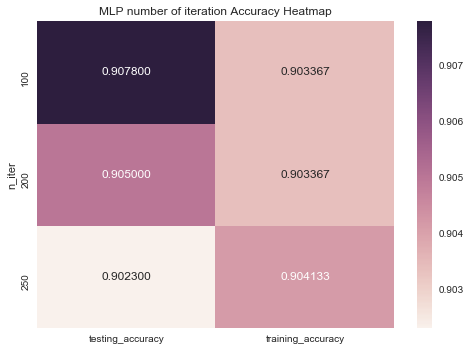

In [17]:
df_mlp_n_iter = pd.DataFrame({ 'n_iter': n_iter_list, 'epoch': epoch_list, 
                              'training_accuracy': train_accuracy_list, 'testing_accuracy': test_accuracy_list})
df_mlp_n_iter_best = df_mlp_n_iter[df_mlp_n_iter['epoch'] == 30]
df_mlp_n_iter_best.set_index('n_iter', inplace = True)
# display the result
plt.clf()

fig_mlp_n_iter = sns.heatmap(df_mlp_n_iter_best[['testing_accuracy', 'training_accuracy']], annot=True, fmt='f')
plt.subplots_adjust(top=0.9)
fig_mlp_n_iter.set_title('MLP number of iteration Accuracy Heatmap')

plt.show()

The best n_iter is 100.

Different n_iter has little effect on accuracy.

In [18]:
# MLP classifier with best parameters
start = timeit.default_timer()
epoch_list = []
cost_list = []
train_accuracy_list = []
test_accuracy_list = []
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden[2]])),
    'h2': tf.Variable(tf.random_normal([n_hidden[2], n_hidden[2]])),
    'out': tf.Variable(tf.random_normal([n_hidden[2], n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden[2]])),
    'b2': tf.Variable(tf.random_normal([n_hidden[2]])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
# construct model
mlp_clf = mlp(X)
# define loss function using L2 regularization
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = mlp_clf, 
                                                              labels= Y))
regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out'])
loss_op = tf.reduce_mean(loss + l2_beta[0] * regularizer)
# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate[1])
train_op = optimizer.minimize(loss_op)
# initialize variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    # training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnisttt.train.num_examples/batch_size[0])
        # loop over all batches
        for k in range(total_batch):
            batch_x, batch_y = mnisttt.train.next_batch(batch_size[0])
            # run optimization op and cost op
            _, c = sess.run([train_op, loss_op], feed_dict = {X: batch_x, Y: batch_y})
            # compute average loss
            avg_cost += c/ total_batch
        # test model
        pred = tf.nn.softmax(mlp_clf)
        correction_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
        # calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correction_prediction, 'float'))
        # display logs per epoch step
        if epoch % display_step == 0:
            epoch_list.append(epoch + 1)
            cost_list.append(avg_cost)
            train_accuracy_list.append(accuracy.eval({X: mnisttt.train.images, 
                                                      Y: mnisttt.train.labels}))
            test_accuracy_list.append(accuracy.eval({X: mnisttt.test.images, 
                                                     Y: mnisttt.test.labels}))
print(n_iter[0], learning_rate[1], l2_beta[0], n_hidden[2])
stop = timeit.default_timer()
print('Running time: %.3f' % (stop - start))

100 0.001 0.01 128
Running time: 237.840


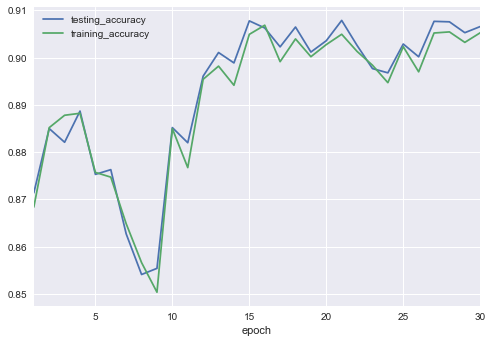

In [19]:
df_mlp_best = pd.DataFrame({ 'epoch': epoch_list, 'training_accuracy': train_accuracy_list, 
                            'testing_accuracy': test_accuracy_list})

df_mlp_best.set_index('epoch', inplace = True)
# display the result
plt.clf()

df_mlp_best.plot.line()

plt.show()

In [150]:
df_mlp_best.iloc[-1]

testing_accuracy     0.906600
training_accuracy    0.905283
Name: 30, dtype: float64

- The lines flatten out starting from epoch 15. 
- The gap between training and testing is small, indicating that there is little overfitting issue.

## LeNet Classifier (Convolutional Neural Network)

In [143]:
# use tensorflow to construct LeNet Classifier
# set parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10
k = 2
s = 1

In [144]:
# set network parameters
nodes_input = 784 # number of input nodes: MNIST image input is 784 pixels (image size is 28 x 28 pixels)
nodes_classes = 10 # number of output nodes: network output is digits 0-9
dropout = 0.80 # probability to keep units, used to avoid overfitting

In [145]:
def conv2d(img, w, s, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides = [1, s, s, 1], padding = 'SAME'), b))
    
def max_pool(img, k):
    return tf.nn.max_pool(img, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [146]:
# define a function to construct the CNN model
def cnn_clf(learn, iters, batch, display_step, ss, kk):
    
    # tensorflow graph input
    x = tf.placeholder(tf.float32, [None, nodes_input]) 
    y = tf.placeholder('float', [None, nodes_classes]) 
    keep_probability = tf.placeholder(tf.float32)
    # store weight and bias for each layer

    # 5x5 convolution layer 1, 1 input, 32 outputs (feature maps)
    weights_c1 = tf.Variable(tf.random_normal([5, 5, 1, 32]))
    bias_c1 = tf.Variable(tf.random_normal([32]))
    
    # 5x5 convolution layer 2, 32 inputs, 64 outputs (feature maps)
    weights_c2 = tf.Variable(tf.random_normal([5, 5, 32, 64]))
    bias_c2 = tf.Variable(tf.random_normal([64]))
    
    # fully connected layer, 7*7*64 inputs, 1024 outputs
    weights_d1 = tf.Variable(tf.random_normal([7 * 7 * 64, 1024]))
    
    # class prediction layer, 1024 inputs, 10 outputs
    weights_out = tf.Variable(tf.random_normal([1024, nodes_classes]))
    bias_d1 = tf.Variable(tf.random_normal([1024]))
    bias_out = tf.Variable(tf.random_normal([nodes_classes]))
    
    # transform 4D input images to a tensor
    _X = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    # construct convolution layer 1
    conv1 = conv2d(_X, weights_c1, s, bias_c1)
    # apply max pooling
    conv1 = max_pool(conv1, k = kk)
    # apply dropout
    conv1 = tf.nn.dropout(conv1, keep_probability)
    
    # construct convolution layer 2
    conv2 = conv2d(conv1, weights_c2, s, bias_c2)
    # apply max pooling
    conv2 = max_pool(conv2, k = kk)
    # apply dropout
    conv2 = tf.nn.dropout(conv2, keep_probability)
    
    # construct fully connected layer
    # reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, weights_d1.get_shape().as_list()[0]])
    # relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, weights_d1), bias_d1))
    # apply dropout
    dense1 = tf.nn.dropout(dense1, keep_probability)
    
    # construct prediction output layer
    prediction = tf.add(tf.matmul(dense1, weights_out), bias_out)
    
    # cost function
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y))
    
    # optimizer (adam optimizer controls the learning rate, could also use gradient descent optimizer)
    optimizer = tf.train.AdamOptimizer(learning_rate=learn).minimize(cost)
    
    # evaluate model
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # initialize variables
    init = tf.initialize_all_variables()
    
    # launch graph
    start = timeit.default_timer()
    
    with tf.Session() as sess:
        sess.run(init)
    
        step = 1
        # train until reach max iterations
        while step * batch < iters:
            batch_xs, batch_ys = mnisttt.train.next_batch(batch)
            # fit training using batch data
            sess.run(optimizer, feed_dict = {x: batch_xs, y: batch_ys, keep_probability: dropout})
            if step % display_step == 0:
                # calculate batch accuracy
                acc = sess.run(accuracy, feed_dict = {x: batch_xs, y: batch_ys, keep_probability: 1.})
                # calculate batch loss
                loss = sess.run(cost, feed_dict = {x: batch_xs, y: batch_ys, keep_probability: 1.})
                print('Iter ' + str(step * batch) + ', Minibatch Loss = ' + '{:.6f}'.format(loss) + ', Training Accuracy = ' + '{:.5f}'.format(acc))
            step += 1
    
        print('Optimization finished')
        # calculate accuracy
        print('Testing Accuracy:', sess.run(accuracy, feed_dict = {x: mnisttt.test.images[:256], y: mnisttt.test.labels[:256], keep_probability: 1.}))
    
    stop = timeit.default_timer()    
    print('Running time: %.3f' % (stop - start))

In [95]:
cnn_clf(learning_rate, training_iters, batch_size, display_step, s, k)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 1280, Minibatch Loss = 23313.761719, Training Accuracy = 0.23438
Iter 2560, Minibatch Loss = 10432.977539, Training Accuracy = 0.43750
Iter 3840, Minibatch Loss = 8121.908203, Training Accuracy = 0.56250
Iter 5120, Minibatch Loss = 6107.663086, Training Accuracy = 0.66406
Iter 6400, Minibatch Loss = 2075.965820, Training Accuracy = 0.79688
Iter 7680, Minibatch Loss = 5106.310547, Training Accuracy = 0.68750
Iter 8960, Minibatch Loss = 3818.327637, Training Accuracy = 0.78906
Iter 10240, Minibatch Loss = 2477.395508, Training Accuracy = 0.82031
Iter 11520, Minibatch Loss = 3683.024658, Training Accuracy = 0.79688
Iter 12800, Minibatch Loss = 2611.934082, Training Accuracy = 0.80469
Iter 14080, Minibatch Loss = 3197.224365, Training Accuracy = 0.80469
Iter 15360, Minibatch Loss = 4007.235352, Training Accuracy = 0.77344
Iter 16640, Minibatch Loss = 3502.112305, Training Accuracy = 0.83594
Iter 17920, Minibatch

In [147]:
# change parameter stride length and rerun CNN
cnn_clf(learning_rate, training_iters, batch_size, display_step, 2, k)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 1280, Minibatch Loss = 32977.109375, Training Accuracy = 0.16406
Iter 2560, Minibatch Loss = 17591.232422, Training Accuracy = 0.32031
Iter 3840, Minibatch Loss = 11733.272461, Training Accuracy = 0.50000
Iter 5120, Minibatch Loss = 5165.752930, Training Accuracy = 0.64062
Iter 6400, Minibatch Loss = 5067.894531, Training Accuracy = 0.75000
Iter 7680, Minibatch Loss = 6236.464844, Training Accuracy = 0.74219
Iter 8960, Minibatch Loss = 4589.412598, Training Accuracy = 0.70312
Iter 10240, Minibatch Loss = 3516.875732, Training Accuracy = 0.71094
Iter 11520, Minibatch Loss = 2479.980713, Training Accuracy = 0.83594
Iter 12800, Minibatch Loss = 2021.064819, Training Accuracy = 0.82031
Iter 14080, Minibatch Loss = 2569.692871, Training Accuracy = 0.78125
Iter 15360, Minibatch Loss = 3311.050293, Training Accuracy = 0.82031
Iter 16640, Minibatch Loss = 1636.859375, Training Accuracy = 0.85938
Iter 17920, Minibatc

In [117]:
# change parameter training iteration and rerun CNN
cnn_clf(learning_rate, 120000, batch_size, display_step, s, k)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 1280, Minibatch Loss = 20854.564453, Training Accuracy = 0.28906
Iter 2560, Minibatch Loss = 12435.306641, Training Accuracy = 0.46875
Iter 3840, Minibatch Loss = 6817.896484, Training Accuracy = 0.59375
Iter 5120, Minibatch Loss = 3068.325684, Training Accuracy = 0.75781
Iter 6400, Minibatch Loss = 5591.728516, Training Accuracy = 0.66406
Iter 7680, Minibatch Loss = 4187.041992, Training Accuracy = 0.78906
Iter 8960, Minibatch Loss = 4401.009277, Training Accuracy = 0.77344
Iter 10240, Minibatch Loss = 3613.146484, Training Accuracy = 0.81250
Iter 11520, Minibatch Loss = 4826.371094, Training Accuracy = 0.72656
Iter 12800, Minibatch Loss = 2019.645752, Training Accuracy = 0.88281
Iter 14080, Minibatch Loss = 3380.142822, Training Accuracy = 0.83594
Iter 15360, Minibatch Loss = 1944.036621, Training Accuracy = 0.87500
Iter 16640, Minibatch Loss = 2013.914673, Training Accuracy = 0.86719
Iter 17920, Minibatch

In [119]:
# change parameter training iteration and rerun CNN
cnn_clf(learning_rate, 150000, batch_size, display_step, s, k )

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 1280, Minibatch Loss = 27504.859375, Training Accuracy = 0.17188
Iter 2560, Minibatch Loss = 15413.415039, Training Accuracy = 0.34375
Iter 3840, Minibatch Loss = 10628.876953, Training Accuracy = 0.48438
Iter 5120, Minibatch Loss = 5648.045410, Training Accuracy = 0.64844
Iter 6400, Minibatch Loss = 6079.767090, Training Accuracy = 0.64844
Iter 7680, Minibatch Loss = 3414.016357, Training Accuracy = 0.76562
Iter 8960, Minibatch Loss = 2977.454346, Training Accuracy = 0.82812
Iter 10240, Minibatch Loss = 3430.736328, Training Accuracy = 0.82031
Iter 11520, Minibatch Loss = 3052.124023, Training Accuracy = 0.78906
Iter 12800, Minibatch Loss = 4245.532227, Training Accuracy = 0.73438
Iter 14080, Minibatch Loss = 2769.477539, Training Accuracy = 0.83594
Iter 15360, Minibatch Loss = 3050.088379, Training Accuracy = 0.79688
Iter 16640, Minibatch Loss = 5092.191406, Training Accuracy = 0.74219
Iter 17920, Minibatc

In [122]:
# change parameter batch size and rerun CNN
cnn_clf(learning_rate, training_iters, 64, display_step, s, k )

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 640, Minibatch Loss = 28445.519531, Training Accuracy = 0.17188
Iter 1280, Minibatch Loss = 20256.158203, Training Accuracy = 0.28125
Iter 1920, Minibatch Loss = 11098.838867, Training Accuracy = 0.48438
Iter 2560, Minibatch Loss = 9050.149414, Training Accuracy = 0.57812
Iter 3200, Minibatch Loss = 6021.517578, Training Accuracy = 0.67188
Iter 3840, Minibatch Loss = 5439.369141, Training Accuracy = 0.67188
Iter 4480, Minibatch Loss = 5690.181152, Training Accuracy = 0.75000
Iter 5120, Minibatch Loss = 2819.688965, Training Accuracy = 0.81250
Iter 5760, Minibatch Loss = 2777.947754, Training Accuracy = 0.84375
Iter 6400, Minibatch Loss = 4894.595703, Training Accuracy = 0.76562
Iter 7040, Minibatch Loss = 3765.545654, Training Accuracy = 0.75000
Iter 7680, Minibatch Loss = 5454.013184, Training Accuracy = 0.71875
Iter 8320, Minibatch Loss = 2099.423828, Training Accuracy = 0.89062
Iter 8960, Minibatch Loss =

In [123]:
# change parameter batch size and rerun CNN
cnn_clf(learning_rate, training_iters, 256, display_step, s, k )

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 2560, Minibatch Loss = 20596.814453, Training Accuracy = 0.30859
Iter 5120, Minibatch Loss = 8847.334961, Training Accuracy = 0.52734
Iter 7680, Minibatch Loss = 7089.670410, Training Accuracy = 0.64844
Iter 10240, Minibatch Loss = 4656.701172, Training Accuracy = 0.76172
Iter 12800, Minibatch Loss = 4361.411133, Training Accuracy = 0.78516
Iter 15360, Minibatch Loss = 3225.518066, Training Accuracy = 0.79297
Iter 17920, Minibatch Loss = 2654.949219, Training Accuracy = 0.83984
Iter 20480, Minibatch Loss = 2911.199707, Training Accuracy = 0.82812
Iter 23040, Minibatch Loss = 2310.946289, Training Accuracy = 0.80859
Iter 25600, Minibatch Loss = 1554.837891, Training Accuracy = 0.88672
Iter 28160, Minibatch Loss = 2529.944336, Training Accuracy = 0.84375
Iter 30720, Minibatch Loss = 2176.948242, Training Accuracy = 0.87891
Iter 33280, Minibatch Loss = 1242.764893, Training Accuracy = 0.91797
Iter 35840, Miniba

The best parameters for CNN are:

- stride length: 1
- training iteration: 150000
- batch size: 64

In [149]:
# get the best accuracy from optimal parameters
cnn_clf(learning_rate, 150000, 64, display_step, 1, k)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 640, Minibatch Loss = 28083.089844, Training Accuracy = 0.20312
Iter 1280, Minibatch Loss = 19585.792969, Training Accuracy = 0.35938
Iter 1920, Minibatch Loss = 8201.539062, Training Accuracy = 0.62500
Iter 2560, Minibatch Loss = 7606.107422, Training Accuracy = 0.67188
Iter 3200, Minibatch Loss = 10280.003906, Training Accuracy = 0.62500
Iter 3840, Minibatch Loss = 6500.102539, Training Accuracy = 0.73438
Iter 4480, Minibatch Loss = 9073.547852, Training Accuracy = 0.64062
Iter 5120, Minibatch Loss = 4330.069336, Training Accuracy = 0.70312
Iter 5760, Minibatch Loss = 2508.709717, Training Accuracy = 0.78125
Iter 6400, Minibatch Loss = 6502.893555, Training Accuracy = 0.71875
Iter 7040, Minibatch Loss = 2948.924805, Training Accuracy = 0.79688
Iter 7680, Minibatch Loss = 3085.156494, Training Accuracy = 0.76562
Iter 8320, Minibatch Loss = 3341.275146, Training Accuracy = 0.81250
Iter 8960, Minibatch Loss =

The optimized CNN has predicting accuracy of 98.05% over testing data, while the best MLP classifier only has 90.66% accuracy on testing data.

The CNN classifier is much more poewrful and accurate than the MLP, because it uses the relationship between pixels for classification. Thus the position of the pixels helps improve the predicting accuracy.